In [1]:
# Imports
import torch
import os 
import sys
from dask_jobqueue import SLURMCluster
from distributed import Client
from pathlib import Path

import do_simulation_bayesimp_discrete as file

In [2]:
# Args setup
ntrial = 100
n = 100
n_int = 2
niter = 1000
front_door = False
minimise = True
add_base_kernel_BO = True

In [3]:
# Cluster creation
cluster = SLURMCluster(
    n_workers=0,
    memory="32GB",
    processes=1,
    cores=1,
    scheduler_options={
        "dashboard_address": ":11111",
        "allowed_failures": 10
    },
    job_cpu=1,
    walltime="3:0:0",
    
    job_extra_directives = ["-p medium,fast,cpu"],
)
cluster.adapt(minimum=0, maximum=200)
client = Client(cluster)

In [4]:
# Submitting jobs
futures = []
for seed in range(ntrial):
        f = client.submit(file.main,
                              seed,
                              n,n_int,
                              niter = niter,
                              front_door = front_door,
                              minimise = minimise,
                              add_base_kernel_BO = add_base_kernel_BO
                             )
        futures += [f]

In [5]:
futures

[<Future: pending, key: main-ad8f001b0f48830a5f7231448115fc8b>,
 <Future: pending, key: main-95ad53ed79307461d7e30b3c47d4f539>,
 <Future: pending, key: main-f861b211bbd884ca8dc845a73d35c7a9>,
 <Future: pending, key: main-b3db7f8e81655ed2c2c448dac1ad10b5>,
 <Future: pending, key: main-4724af6a562461304aa6c69f5dfbe745>,
 <Future: pending, key: main-224a6c75fd737cf4cf9462d91e6b8a30>,
 <Future: pending, key: main-3855d8f7f316984d4a2b86c4a080db6d>,
 <Future: pending, key: main-675806a8a43dd7cc2fa5594490508002>,
 <Future: pending, key: main-557216e868a1e76fbcb74be997abe289>,
 <Future: pending, key: main-dd7d610d557b75e3b5db5c32e627b8a8>,
 <Future: pending, key: main-f0161b40377f1f9083879818505d8106>,
 <Future: pending, key: main-a06de8f0fd574ea57c8bd38a8229fe7a>,
 <Future: pending, key: main-0348a79fd5631e767e2b68015d42db4a>,
 <Future: pending, key: main-52f2698928aa3e7a41251edfc76bd8f5>,
 <Future: pending, key: main-aef49593e47ae8d1fbaf43a890deca02>,
 <Future: pending, key: main-c8db2a22c6e

In [6]:
# Getting results
results = client.gather(futures)

In [7]:
# Closing client
client.close()
cluster.close()

In [15]:
mean = torch.zeros(ntrial)
se = torch.zeros(ntrial)
fracs = torch.zeros((ntrial,101))
for i in range(ntrial):
    mean[i] = results[i]['post_moments'][0]
    se[i] =  results[i]['post_moments'][1]**0.5
    fracs[i] =  results[i]['post_levels']
((0 <= (mean + 1.965*se) ) * (0 >= (mean - 1.965*se))).float().mean()

tensor(0.9600)

In [16]:
fracs.mean(0)[[80,90,95]]

tensor([0.8400, 0.8900, 0.9600])

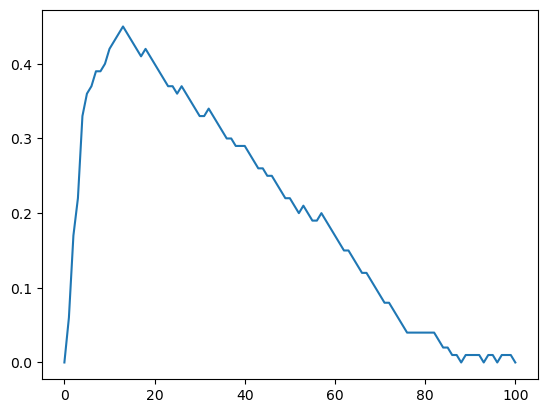

In [17]:
import matplotlib.pyplot as plt
import torch
plt.plot((torch.linspace(0,1,101)-fracs.mean(0)).abs())

(tensor(0.1249), tensor(0.2123))

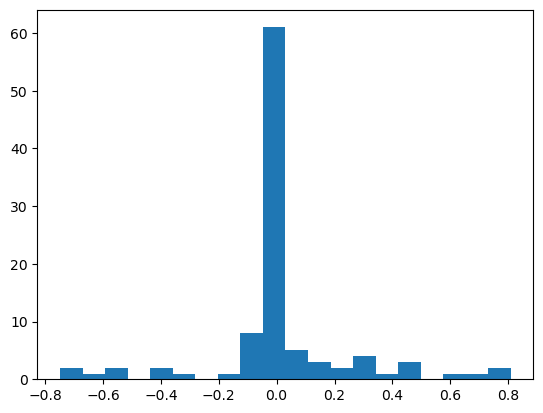

In [20]:
import matplotlib.pyplot as plt
plt.hist(mean, bins = 20);
mean.abs().mean(), mean.abs().std()

In [12]:
# Saving results
torch.save(obj = results,
           f = "simulation_bayesimp_ntrial={0}_n={1}_frontdoor={2}_discrete.pt".format(ntrial,
                                                                                           n,
                                                                                           front_door,
                                                                                           minimise,
                                                                                           add_base_kernel_BO)
          )